# TIES5830 Assignment 3

### Author: Heikki Kurhinen

## Task 1
Use EI and the mean prediction to solve any single objective benchmark problem (e.g.
Ackley, Rosenblock, sphere etc.) with any single objective optimizer (preferably GA). Set
max exact function evaluations to 50 (start with 50 design points).

In [24]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.optimize import rosen, minimize
import numpy as np

# Helper function to build suitable function for minimization using provided surrogate
def surrogate_f(surrogate):
    return lambda a : surrogate.predict([a])[0]

# Perform optimization by using Kriging surrogates mean prediction as objective
def mean_prediction(f, n_initial_points, n_eval):
    xs = np.random.uniform(low=-2, high=2, size=(n_initial_points,3))
    ys = [f(x) for x in xs]
    surrogate = GaussianProcessRegressor()
    surrogate.fit(xs, ys)
    f_sur = surrogate_f(surrogate)
    x = None
    for i in range(n_eval):
        res = minimize(f_sur, (0, 0, 0), method='L-BFGS-B', bounds=((-2, 2), (-2, 2), (-2, 2)))
        x = res.x
        xs = np.append(xs, [res.x], axis=0)
        ys = np.append(ys, f(res.x))
        surrogate = GaussianProcessRegressor()
        surrogate.fit(xs, ys)
        f_sur = surrogate_f(surrogate)
    print(f"Optimization done with input: {x} and function value: {f(x)}")

for n in range(10):
    mean_prediction(rosen, 50, 50)

Optimization done with input: [0.72175605 0.52372846 0.27457562] and function value: 0.3050444878027309
Optimization done with input: [-0.01070371 -0.00159543  0.02583271] and function value: 2.0917275416643277
Optimization done with input: [0.83574628 0.70132436 0.49058893] and function value: 0.11716062125461887
Optimization done with input: [-0.5152896   0.27527332  0.07040997] and function value: 2.8337162706920687
Optimization done with input: [0.5124606  0.26095468 0.06277761] and function value: 0.786988555117887
Optimization done with input: [0.18874475 0.04636399 0.00182365] and function value: 1.5791008448813093
Optimization done with input: [0.78666566 0.62394406 0.38291281] and function value: 0.19361937199006923
Optimization done with input: [0.69621391 0.58205018 0.29107738] and function value: 1.4419820247188937
Optimization done with input: [0.51200736 0.27460124 0.06661271] and function value: 0.7875716100036051
Optimization done with input: [-0.51117699  0.27515324  0

In [32]:
# Use Bayesian optimization using Gaussian Processes from scikit-optimize
from skopt import gp_minimize

def expected_improvement(f, n_initial_points, n_eval):
    res = gp_minimize(f,
                      [(-2.0, 2.0), (-2.0, 2.0), (-2.0, 2.0)],
                      acq_func="EI",
                      n_initial_points=n_initial_points,
                      n_calls=n_eval)
    print(f"Optimization done with input: {res.x} and function value: {f(res.x)}")

for n in range(10):
    expected_improvement(rosen, 50, 50)

Optimization done with input: [-0.9297672229499037, 0.9380217815948417, 0.35017746101632996] and function value: 32.32786526124202
Optimization done with input: [-0.6113056646627018, 0.09210607156188688, -0.2272931540348968] and function value: 16.908852545238418
Optimization done with input: [-0.46060346535706964, -0.03202183140796899, -0.29342842477800524] and function value: 17.83099637131972
Optimization done with input: [-0.11655574262603352, -0.046538071051179575, 0.47890989366119596] and function value: 25.431913768847245
Optimization done with input: [-0.7162045302879478, 0.46542727847875964, 1.172265811713185] and function value: 94.78236078227212
Optimization done with input: [-0.365762190849384, -0.06029641133733499, 0.10523813741730592] and function value: 7.7884834483741505
Optimization done with input: [-0.372435476254954, 0.7959666576803115, 1.0851804868752102] and function value: 65.51992152572898
Optimization done with input: [0.6064671404206288, 0.800846615707473, 0.3

## Was the solutions found by EI better?

No, I implemented mean prediction and used Bayesian optimization using Gaussian Processes from scikit-optimize where I used the EI as acquisition function. I tested both methods while optimizing Rosenbrock function with 3 input parameters and bounds from -2 to 2 for each of the parameters.

With 10 test runs on both methods, they achieved average function values of:
- Mean prediction: 1.30
- EI: 32.01

## Task 2
Solve any benchmark problems (K=2 and 5, n=10) with ParEGO and LCB. Start with 109
design points. Compare the hypervolume of the solutions after 100 exact function
evaluations.

In [111]:
from desdeo_problem.testproblems.TestProblems import test_problem_builder
from scipy.stats import qmc, norm

# Method for generating samples using LHS-sampling
def lhs(d, count):
    sampler = qmc.LatinHypercube(d=d)
    sample = sampler.random(n=count)
    return sample

In [114]:
# Scalarization method for use with parEGO
def scalarize(n_objectives, ys, rho):
    theta = np.random.random_sample((n_objectives))
    sum_theta = np.sum(theta)
    theta = theta / sum_theta

    theta_f = theta * ys
    max_k = np.max(theta_f, axis = 1)
    rho_sum_theta_f = rho * np.sum(theta_f, axis = 1)
    f_theta = max_k + rho_sum_theta_f
    return f_theta

In [131]:
# Objective function builder for parEGO
def build_obj(model, xs, f_theta, xi):
    def obj(x):
        if np.any(np.all(xs == x, axis=1)):
            return 1.0e5
        else:
            mean, std = model.predict(np.atleast_2d(x), return_std=True)
            current_max = f_theta.max()
            Z = (current_max - mean[0] - xi) / std
            ei = (-1) * (Z * std) * norm.cdf(Z) + std * norm.pdf(Z)
            return ei
    return obj

# Expected improvement for parEGO
def EI(xs, f_theta, bounds, xi):
    model = GaussianProcessRegressor()
    model.fit(xs, f_theta)
    obj = build_obj(model, xs, f_theta, xi)
    res = minimize(obj, np.zeros(len(bounds)), method='L-BFGS-B', bounds=bounds)
    return res

# parEGO algorithm
def parEGO(problem_name, n_of_objectives, n_of_variables):
    p = test_problem_builder(problem_name, n_of_objectives=n_of_objectives, n_of_variables=n_of_variables)
    f = lambda a : p.evaluate(a).objectives[0]
    initial_num = 109
    max_iter = 100
    bounds = [[0, 1] for _ in range(n_of_variables)]
    xs = lhs(n_of_variables, initial_num)
    ys = np.array([f(xs[i]) for i in range(initial_num)])
    rho = 0.05
    xi = 0
    res_x = np.empty((1, n_of_variables))
    res_y = np.empty((1, n_of_objectives))
    for i in range(max_iter):
        f_theta = scalarize(ys.shape[1], ys, rho)
        res = EI(xs, f_theta, bounds, xi)
        xs = np.append(xs, [res.x], axis=0)
        res_x = np.append(res_x, [res.x], axis=0)
        next_y = f(res.x)
        ys = np.append(ys, [next_y], axis=0)
        res_y = np.append(res_y, [next_y], axis=0)
    return res_x, res_y

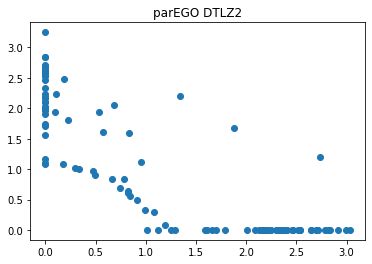

In [135]:
from desdeo_tools.utilities.quality_indicator import hypervolume_indicator
import matplotlib.pyplot as plt

# Approximates the reference point (slighty worse than nadir)
def calculateReferencePoint(nadir):
    return nadir + 0.0001

# Calculates hypervolume for given front, uses point which is slighty worse than nadir
# as reference point
def calculateHypervolume(front):
    nadir = np.max(front, axis=0)
    ref = calculateReferencePoint(nadir)
    return hypervolume_indicator(front, ref)

# Helper function to draw plots
def plotFront(data, title):
    plt.scatter(data[:,0],data[:,1])
    plt.title(title)
    plt.show()
    
_, dtlz2ParEGOFront = parEGO("DTLZ2", 2, 10)
_, dtlz5ParEGOFront = parEGO("DTLZ5", 5, 10)
plotFront(dtlz2ParEGOFront, "parEGO DTLZ2")

In [136]:
print(f"Hypervolume for parEGO algorithm with DTLZ2 test problem: {calculateHypervolume(dtlz2ParEGOFront)}")
print(f"Hypervolume for parEGO algorithm with DTLZ5 test problem: {calculateHypervolume(dtlz5ParEGOFront)}")

Hypervolume for parEGO algorithm with DTLZ2 test problem: 7.5077833583845415
Hypervolume for parEGO algorithm with DTLZ5 test problem: 2.2195163779437426


Hypervolumes for test problems with parEGO algorithm were:
- DTLZ2: 7.5077833583845415
- DTLZ5: 2.2195163779437426

Unfortunately I couldn't figure out working method on extending the LCB based optimization to multiobjective problems.